In [ ]:
#!pip install torch torchvision

In [ ]:
%matplotlib inline

In [ ]:
import torch
import math
from matplotlib import pyplot
import numpy as np
from IPython.core.debugger import set_trace


Introduction to `torch.nn`
============================


PyTorch provides the modules and classes:
* `torch.nn <https://pytorch.org/docs/stable/nn.html>`_ ,: Contains the different layers to be used to create a neural network.
* `torch.optim <https://pytorch.org/docs/stable/optim.html>`_ ,: contains the optimisation algorithms to train a neural network.
* `Dataset <https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset>`_ : Allows to create datasets (training, validation and test datasets) with input and target data being **Tensor** objects that can be processed by a Neural Network.  
* `DataLoader <https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader>`_: Allows to create **batches** of a dataset to perform **mini-batch gradient descent algorithms. **

to help you create and train neural networks.

We will first train basic neural net
on **the MNIST data** set without using any features from these models; we will
initially only use the most basic PyTorch tensor functionality. Then, we will
incrementally add one feature from ``torch.nn``, ``torch.optim``, ``Dataset``, or
``DataLoader`` at a time, showing exactly what each piece does, and how it
works to make the code either more concise, or more flexible.

# Pytorch `Tensor` objects

In [ ]:
import numpy as np
array = np.random.randn(64,1000)
print(array.shape)
tensor = torch.tensor(array, dtype=torch.float32)
print(tensor.shape)
print(tensor.dtype)
tensor_2 = torch.randn(64, 1000)
print(tensor_2.shape), print(tensor_2.size())
print(tensor_2.dtype)
zero_tensor = torch.zeros(64,10)
print(zero_tensor[0])
one_tensor = torch.ones(64,10)
print(one_tensor[0])

(64, 1000)
torch.Size([64, 1000])
torch.float32
torch.Size([64, 1000])
torch.Size([64, 1000])
torch.float32
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
# RESIZING
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])


In [ ]:
# OPERATIONS
x = torch.randn(2, 2)
print(x)
y = torch.randn(2, 2)
print(y)
print(x + y)

tensor([[-0.4543,  0.5861],
        [-0.9657,  1.1146]])
tensor([[-0.8701,  2.1171],
        [-0.4888,  0.1595]])
tensor([[-1.3243,  2.7032],
        [-1.4544,  1.2741]])


In [ ]:
# OPERATIONS - BROADCASTING
x = torch.randn(2, 2)
print(x)
y = torch.ones(2)
print(x+y)

tensor([[1.5766, 0.9637],
        [0.3108, 0.2199]])
tensor([[2.5766, 1.9637],
        [1.3108, 1.2199]])


In [ ]:
# OPERATIONS - mean, sum
x = torch.randn(2, 2)
print(x)
print(x.mean())
print(x.mean(dim=1))
print(x.sum())
print(x.sum(dim=0))

tensor([[ 0.6575,  0.7742],
        [-1.9057,  0.1253]])
tensor(-0.0872)
tensor([ 0.7159, -0.8902])
tensor(-0.3486)
tensor([-1.2482,  0.8996])


In [ ]:
# OPERATIONS - log, exp
x = torch.randn(3, 2)
print(x)
print(x.exp())
y = torch.zeros(3,2)
print(y.exp())
z = torch.ones(2,2)
print(z.log())

tensor([[ 3.4353,  0.4304],
        [ 0.7875, -0.2651],
        [ 1.0675,  0.8801]])
tensor([[31.0399,  1.5379],
        [ 2.1979,  0.7671],
        [ 2.9080,  2.4113]])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 0.]])


# MNIST data setup
We will use the classic MNIST <https://pytorch.org/docs/stable/torchvision/datasets.html#mnist>_ dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

From this dataset, to goal will be to build a classifier able to classify correctly the hand-written digits.


In [ ]:
from torchvision.datasets import MNIST

In [ ]:
data_path = "/Users/alicemartin/14_Teaching/UM6P/data" # put your own path here.
mnist_dataset = MNIST(root= data_path, download=True)

In [ ]:
x_train = mnist_dataset.train_data
y_train = mnist_dataset.train_labels
print("x_train type", x_train.dtype)
print("x_train shape", x_train.shape) # (60000, 28, 28)
print("y_train type", y_train.dtype)
print("y_train shape", y_train.shape) # (60000)

x_train type torch.uint8
x_train shape torch.Size([60000, 28, 28])
y_train type torch.int64
y_train shape torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


PyTorch uses ``torch.tensor`` objects. y_train and X_train are such objects. 



Each image is **28 x 28** pixels. Let's plot one of them.

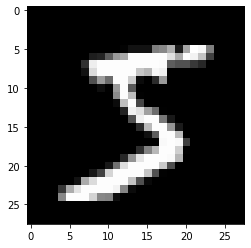

In [ ]:
pyplot.imshow(x_train[0], cmap="gray")

For the rest of the tutorial, we will reshape our input data `x_train` from a 2D tensor of size (28*28) to a 1D one of size (784). 

In [ ]:
x_train = x_train.view(x_train.shape[0], -1).float() # convert to a float tensor. 
print(x_train.shape)
print(x_train.dtype)

torch.Size([48000, 784])
torch.float32


Neural net from scratch (no torch.nn)
---------------------------------------------

Let's first create a model using nothing but **PyTorch tensor operations**. 

PyTorch provides methods to create random or zero-filled tensors, which we will
use to create **our weights and bias** for a simple linear model. These are just regular
tensors, with one very special addition: we tell PyTorch that they require a
gradient. This causes PyTorch to record all of the operations done on the tensor,
so that it can calculate the gradient during back-propagation *automatically*!

For the weights, we set ``requires_grad`` *after* the initialization, since we
don't want that step included in the gradient. (Note that a trailling ``_`` in
PyTorch signifies that the operation is performed in-place.)

We are initializing the weights here with
   `Xavier initialisation <http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf>`_
   (by multiplying with 1/sqrt(n))


In [ ]:
weights = torch.randn(784, 10) / math.sqrt(784) # 784 is the dimension of the input vector, 10 is the dimension of the output vector.
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch's ability to calculate gradients automatically, we can
use any standard Python function (or callable object) as a model! 
So
let's just write a plain matrix multiplication and broadcasted addition
to create a simple linear model. We also need an activation function, so
we'll write `log_softmax` and use it. 



### Exercice 1: 
1. Implement the equation of the hidden layer $h=Wx+b$ using the weights and bias defined above by completing the `layer` function below. 
> **Tip**: You can use the 'torch.matmul' function: 
https://pytorch.org/docs/stable/generated/torch.matmul.html
2. Implement the equation of the softmax output layer using the `logsoftmax` function below: $logsoftmax(x_i) = \log (e^{x_i} / \sum_j e^{x_j})$
> **Tip**: use the `.exp()` and `.log()` function of pytorch.
3. Implement the total model using in the `model` function using the 2 previous functions. 

In [ ]:
def layer(xb):
  # h= 
  return h 

def logsoftmax(x): # this one is better: more stable. 

def model(xb):

We will call
our function on one batch of data (in this case, 64 images).  This is
one *forward pass*.  Note that our predictions won't be any better than
random at this stage, since we start with random weights.


In [ ]:
n = x_train.shape[0] # number of training samples
bs = 64  # batch size
xb = x_train[0:bs]  # a mini-batch from x
logpreds = model(xb)  # predictions
logpreds[0], logpreds.shape
print(logpreds[0], logpreds.shape)

tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
       grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the ``logpreds`` tensor contains not only the tensor values, but also a
gradient function. We'll use this later to do backprop.

Let's implement negative log-likelihood to use as the loss function
(again, we can just use standard Python):



### Exercice 2: 
 Implement the negative log-likelihood (equivalent to the cross-entropy in the classification setting) using the `nll` function below:  

 $nll = - 1/N \sum_i * \log f(x_i)[y_i]$  
 With $N$ the number of training samples in the batch, $y_i$ the target value for the i-th sample, and $f(x_i)$ the ouput of the neural network for the i-th training input sample of the batch. 

In [ ]:
def nll(logpred, target):
  # nll = 
  return nll

loss_func = nll

Let's check our loss with our random model, so we can see if we improve
after a backprop pass later.



In [ ]:
yb = y_train[0:bs]
print(loss_func(logpreds, yb))

tensor(inf, grad_fn=<NegBackward>)


### Exercice 3: Implement the accuracy function.
Let's also implement a function to calculate the accuracy of our model.  

For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.

**Tip**: you can use the 'torch.argmax' function: https://pytorch.org/docs/stable/generated/torch.argmax.html

In [ ]:
def accuracy(out, yb):
    # acc= 
    return acc

Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.



In [ ]:
print(accuracy(logpreds, yb))

tensor(0.1250)


We can now run a training loop.  For each iteration, we will:

- select a mini-batch of data (of size ``bs``)
- use the model to make predictions
- calculate the loss
- ``loss.backward()`` updates the gradients of the model, in this case, ``weights``
  and ``bias``.

We now use these gradients to update the weights and bias.  We do this
within the ``torch.no_grad()`` context manager, because we do not want these
actions to be recorded for our next calculation of the gradient.  You can read
more about how PyTorch's Autograd records operations
`here <https://pytorch.org/docs/stable/notes/autograd.html>`_.

We then set the
gradients to zero, so that we are ready for the next loop.
Otherwise, our gradients would record a running tally of all the operations
that had happened (i.e. ``loss.backward()`` *adds* the gradients to whatever is
already stored, rather than replacing them).

In [ ]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i] # mini-batch input data 
        yb = y_train[start_i:end_i] # mini-batch target data
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
          # manual update of the model parameters (weights and bias) using Stochastic Gradient Descent (SGD)
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_() # resetting the gradients to 0.
            bias.grad.zero_()

That's it: we've created and trained a minimal neural network (in this case, a
logistic regression, since we have no hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have.



In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(nan, grad_fn=<NegBackward>) tensor(0.0625)


Using torch.nn.functional
------------------------------

We will now refactor our code, so that it does the same thing as before, only
we'll start taking advantage of PyTorch's ``nn`` classes to make it more concise
and flexible.

The first and easiest step is to make our code shorter by replacing our
hand-written activation and loss functions with those from ``torch.nn.functional``
(which is generally imported into the namespace ``F`` by convention). This module
contains all the functions in the ``torch.nn`` library (whereas other parts of the
library contain classes).  

If you're using **negative log likelihood loss** and **log softmax activation**,
then Pytorch provides a single function ``F.cross_entropy`` that combines
the two. So we can even remove the activation function from our model.


In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return torch.matmul(xb, weights) + bias

Note that we no longer call ``log_softmax`` in the ``model`` function. Let's
confirm that our loss and accuracy are the same as before:



In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(nan, grad_fn=<NllLossBackward>) tensor(0.0625)


Refactor using nn.Module
-----------------------------
Next up, we'll use ``nn.Module`` and ``nn.Parameter``, for a clearer and more
concise training loop. We subclass ``nn.Module`` (which itself is a class and
able to keep track of state).  In this case, we want to create a class that
holds our weights, bias, and method for the forward step.  ``nn.Module`` has a
number of attributes and methods (such as ``.parameters()`` and ``.zero_grad()``)
which we will be using.



In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return torch.matmul(xb, weights) + bias

Since we're now using an object instead of just using a function, we
first have to instantiate our model:



In [ ]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that
``nn.Module`` objects are used as if they are functions (i.e they are
*callable*), but behind the scenes Pytorch will call our ``forward``
method automatically.



In [ ]:
print(loss_func(model(xb), yb))

tensor(137.5097, grad_fn=<NllLossBackward>)


Previously for our training loop we had to update the values for each parameter
by name, and manually zero out the grads for each parameter separately, like this:
::

  `with torch.no_grad():`  

      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()


Now we can take advantage of `model.parameters()` and `model.zero_grad()` (which
are both defined by PyTorch for ``nn.Module``) to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly
if we had a more complicated model:
::
  `with torch.no_grad():`

      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()


We'll wrap our little training loop in a ``fit`` function so we can run it
again later.



In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
              # manual update of all the parameters using SGD
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let's double-check that our loss has gone down:



In [ ]:
print(loss_func(model(xb), yb))

tensor(0., grad_fn=<NllLossBackward>)


Refactor using nn.Linear
-------------------------
 Instead of manually defining and
initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @
self.weights + self.bias``, we will instead use the Pytorch class
`nn.Linear <https://pytorch.org/docs/stable/nn.html#linear-layers>`_ for a
linear layer, which does all that for us. 
Pytorch has many types of
predefined layers that can greatly simplify our code, and often makes it
faster too.



### Exercice 4. 
Using the Class `Mnist_Logistic` below, implement: 
1. Inside the `def` function a nn.Linear layer with the same dimensions as above.
2. Inside the `forward` function (corresponding to a forward pass), the forward pass of this linear layer on input data $x_b$. 

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        #self.lin = 

    def forward(self, xb):

We instantiate our model and calculate the loss in the same way as before:



In [ ]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(78.9874, grad_fn=<NllLossBackward>)


We are still able to use our same ``fit`` method as before.



In [ ]:
fit()

print(loss_func(model(xb), yb))

tensor(0., grad_fn=<NllLossBackward>)


Refactor using optim
------------------------------

Pytorch also has a package with various optimization algorithms, ``torch.optim``.  

We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:
::  

  `with torch.no_grad():`

      for p in model.parameters(): 
      p -= p.grad * lr 
      model.zero_grad()

and instead use just:
:: 

  `opt.step()`  
  `opt.zero_grad()`

(``optim.zero_grad()`` resets the gradient to 0 and we need to call it before
computing the gradient for the next minibatch.)


In [ ]:
from torch import optim

We'll define a little function to create our model and optimizer so we
can reuse it in the future.



In [ ]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(66.1239, grad_fn=<NllLossBackward>)


### Exercice 5
Refactor the function `fit` implemented above using `opt.step()` & `opt.zero_grad()`.

In [ ]:
def fit():
  pass
fit()
print(loss_func(model(xb), yb))

tensor(0., grad_fn=<NllLossBackward>)


Refactor using Dataset
------------------------------

PyTorch has an abstract Dataset class.  
A Dataset can be anything that has
a ``__len__`` function (called by Python's standard ``len`` function) and
a ``__getitem__`` function as a way of indexing into it.  

`This tutorial <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>`_
walks through a nice example of creating a custom ``FacialLandmarkDataset`` class
as a subclass of ``Dataset``.

PyTorch's `TensorDataset <https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset>`_
is a Dataset wrapping tensors. 
By defining a length and way of indexing,
this also gives us a way to iterate, index, and slice along the first
dimension of a tensor. This will make it easier to access both the
independent and dependent variables in the same line as we train.

In [ ]:
from torch.utils.data import TensorDataset

Both ``x_train`` and ``y_train`` can be combined in a single ``TensorDataset``,
which will be easier to iterate over and slice.



In [ ]:
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:
::
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]


Now, we can do these two steps together:
::
    xb,yb = train_ds[i*bs : i*bs+bs]




In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0., grad_fn=<NllLossBackward>)


Refactor using DataLoader
------------------------------

Pytorch's ``DataLoader`` is responsible for managing batches. You can
create a ``DataLoader`` from any ``Dataset``. 
``DataLoader`` makes it easier
to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``,
the DataLoader gives us each minibatch automatically.

In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Previously, our loop iterated over batches (xb, yb) like this:
::
      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:
::
      for xb,yb in train_dl:
          pred = model(xb)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0., grad_fn=<NllLossBackward>)


Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effecive models in practice.

Add validation
-----------------------

In section 1, we were just trying to get a reasonable training loop set up for
use on our training data.  In reality, you **always** should also have
a `validation set <https://www.fast.ai/2017/11/13/validation-sets/>`_, in order
to identify if you are overfitting.

Shuffling the training data is
`important <https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks>`_
to prevent correlation between batches and overfitting. On the other hand, the
validation loss will be identical whether we shuffle the validation set or not.
Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly.

### Exercice 5: 
1. Split the training dataset between a train dataset and a validation dataset.   
You can use for example the `train_test_split` function of sci-kit learn. 

2. Create a train TensorDataset, a validation TensorDataset, a train DataLoader, and a validation DataLoader.

In [ ]:
from sklearn.model_selection import train_test_split

torch.Size([48000, 784])
torch.Size([12000, 784])
torch.Size([48000])
torch.Size([12000])


In [ ]:
#train_ds = 
#train_dl = 

#valid_ds =
#valid_dl =

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(8295.5615)
1 tensor(6910.6675)


Create fit() and get_data()
----------------------------------

We'll now do a little refactoring of our own. Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit`` runs the necessary operations to train our model and compute the
training and validation losses for each epoch.



In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data`` returns dataloaders for the training and validation sets.



In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 8078.89233984375
1 7892.56967578125


Closing thoughts
-----------------

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch. To see how simple training a model
can now be, take a look at the `mnist_sample` sample notebook.

Of course, there are many things you'll want to add, such as data augmentation,
hyperparameter tuning, monitoring training, transfer learning, and so forth.
These features are available in the fastai library, which has been developed
using the same design approach shown in this tutorial, providing a natural
next step for practitioners looking to take their models further.

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

